In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python


E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
from sklearn.model_selection import train_test_split
import os
from PIL import Image
from skimage.color import rgb2gray
import h5py
from keras.preprocessing.image import array_to_img, ImageDataGenerator
from keras.layers import Dense, concatenate, Flatten, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.models import Model, load_model, Sequential
from keras.applications.inception_v3 import InceptionV3

Using TensorFlow backend.


In [2]:
import tensorflow

In [3]:
from openslide import open_slide, __library_version__ as openslide_version

# Load Back

We load our data from the saved dataset on the GCP. For this notebook, the data loaded is the augmented dataset created for levels 4 and 5 to run a multi-scale experiment

In [4]:
level_1 = 4
level_2 = 5
# slide_subimages_loaded_zoom_in = np.load('train_subimages' +  str(level_1) +'.npy')
# slide_subimages_loaded_zoom_out = np.load('train_subimages' + str(level_2) + '.npy')
# slide_sublabels_loaded = np.load('train_labels_shared' +'.npy')

# print(slide_subimages_loaded_zoom_in.shape)
# print(slide_subimages_loaded_zoom_out.shape)
# print(slide_sublabels_loaded.shape)

In [5]:
augmented_slide_subimages_zoom_in = np.load('train_subimages_augmented' + str(level_1) +'.npy')
augmented_slide_subimages_zoom_out = np.load('train_subimages_augmented' + str(level_2) + '.npy')
augmented_slide_sublabels_loaded = np.load('train_labels_shared_augmented' +'.npy')

print(augmented_slide_subimages_zoom_in.shape)
print(augmented_slide_subimages_zoom_out.shape)
print(augmented_slide_sublabels_loaded.shape)

(35135, 150, 150, 3)
(35135, 150, 150, 3)
(35135,)


PLEASE NOTE : Augmented experiment is with a balanced dataset. The 35135 samples shown above have an almost equal distribution of tumor and healthy images

In [6]:
X_train_1_aug, X_val_1_aug, y_train_1_aug, y_val_1_Aug = train_test_split(augmented_slide_subimages_zoom_in, augmented_slide_sublabels_loaded, test_size=0.33, random_state=42)


In [7]:
X_train_2_aug, X_val_2_aug, y_train_2_aug, y_val_2_Aug = train_test_split(augmented_slide_subimages_zoom_out, augmented_slide_sublabels_loaded, test_size=0.33, random_state=42)


# Model Building

Model creation Approach

- We have experimented with transfer learning and convolution model. While transfer learning is made of huge inception structures, the convolution model is  relatively smaller
- We basically tried to initially make 2 separate models, feed in data of level 4 in one and level 5 in one. In the end we planned to take the average of the predictions obtained from these two models


We train 6 models using two magnification levels:
 Model 1 : Using transfer learning at level 4 (used in averaging)
 Model 2 : Using transfer learning at level 5 (used in averaging)
 Model 3 : Merged model using transfer learning at levels 4, 5

 Model 4 : Using self-built CNNs at level 4 (used in averaging)
 Model 5 : Using self-built CNNs at level 5 (used in averaging)
 Model 6 : Merged model using self-built CNNs at levels 4, 5

 The merged models take inputs from a helper data generator, which feeds in the values

We have defined a helper data generator below which helps us feed training and validation data in parallel to our model

In [8]:
def generate_data(X1, X2, y):
  """
  Here, X1 is data corresponding to 1 zoom level and X2 to another. y is shared between both
  """
  while True:   
      index = np.random.permutation(X1.shape[0])
      datagen = ImageDataGenerator()

      batches = datagen.flow(X1[index], y[index], batch_size=32)
      index0 = 0
      #Image generator created which yields data to be fed into our model in parallel
      for batch in batches:
          index1 = index0 + batch[0].shape[0]
          yield [batch[0], X2[index[index0:index1]]], batch[1]
          index0 = index1
          if index1 >= X1.shape[0]:
              break

#store data generators for training and val
train_generator = generate_data(X_train_1_aug, X_train_2_aug, y_train_1_aug)
val_generator = generate_data(X_val_1_aug, X_val_2_aug, y_val_1_Aug)

In [9]:
from keras import models
from keras import layers
from keras import applications

## **Transfer Learning**

## **Model based on average of two models**

Building 2 individual transfer learning models. Different zoom levels fed to each

In [17]:
from keras import models
from keras import layers
from keras import applications

window_size = 150

conv_base = applications.inception_v3.InceptionV3(weights='imagenet',
                                        include_top=False,
                                        input_shape=(window_size, window_size, 3))

model_transfer_sum_1 = models.Sequential()
model_transfer_sum_1.add(conv_base)
model_transfer_sum_1.add(layers.Flatten())
model_transfer_sum_1.add(layers.Dense(256, activation='relu'))
model_transfer_sum_1.add(layers.Dropout(.5))
model_transfer_sum_1.add(layers.Dense(1, activation='sigmoid'))


model_transfer_sum_1.summary()

87916544/87910968 [==============================] - 1s 0us/step

In [18]:
conv_base_2 = applications.inception_v3.InceptionV3(weights='imagenet',
                                        include_top=False,
                                        input_shape=(window_size, window_size, 3))

model_transfer_sum_2 = models.Sequential()
model_transfer_sum_2.add(conv_base_2)
model_transfer_sum_2.add(layers.Flatten())
model_transfer_sum_2.add(layers.Dense(256, activation='relu'))
model_transfer_sum_2.add(layers.Dropout(.5))
model_transfer_sum_2.add(layers.Dense(1, activation='sigmoid'))


model_transfer_sum_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 26,521,889
Trainable params: 26,487,457
Non-trainable params: 34,432
_________________________________________________________________


In [19]:
from keras import optimizers

model_transfer_sum_1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history_1 = model_transfer_sum_1.fit(X_train_1_aug,
          y_train_1_aug,
          epochs=5,
          batch_size=128,
          validation_data=(X_val_1_aug, y_val_1_Aug))


model_filename = "Transfer_learning_multi_scale_simple_avg_1" + '_MODEL.h5' 
model_transfer_sum_1.save(model_filename)

Train on 23540 samples, validate on 11595 samples
Epoch 1/5
23540/23540 [==============================] - 102s 4ms/step - loss: 0.3661 - acc: 0.8418 - val_loss: 0.2461 - val_acc: 0.9037

In [21]:
from keras import optimizers

model_transfer_sum_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history_2 = model_transfer_sum_2.fit(X_train_2_aug,
          y_train_2_aug,
          epochs=7,
          batch_size=128,
          validation_data=(X_val_2_aug, y_val_2_Aug))


model_filename = "Transfer_learning_multi_scale_simple_avg_2" + '_MODEL.h5' 
model_transfer_sum_2.save(model_filename)

Train on 23540 samples, validate on 11595 samples
Epoch 1/7
23540/23540 [==============================] - 88s 4ms/step - loss: 0.1701 - acc: 0.9357 - val_loss: 0.1351 - val_acc: 0.9526

## **Merged transfer learning model**

Below model is designed to take inputs from 2 zoom levels and give a single output

In [11]:
window_size = 150
conv1_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(window_size, window_size, 3))
conv2_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(window_size, window_size, 3))


for layer in conv2_base.layers:
    layer.name = layer.name + str("_zoom_out")

input1 = conv1_base.input
output1 = conv1_base.output

input2 = conv2_base.input
output2 = conv2_base.output

# merge conv outputs
concatenated = concatenate([output1, output2])

flat = Flatten()(concatenated)
dense1 = Dense(256, activation='relu')(flat)
drop1 = Dropout(.5)(dense1)
final_output = Dense(1, activation='sigmoid')(drop1)

# create final model
#2 inputs sent in, one output
model_transfer = Model([input1, input2], final_output)

In [12]:


from keras import optimizers

model_transfer.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = model_transfer.fit_generator(
    train_generator,
    epochs=10,
    steps_per_epoch=128,
    validation_steps=64,
    validation_data=val_generator)

model_filename_2 = "Merged_transfer_multi_scale" + '_MODEL.h5' 
model_transfer.save(model_filename_2)

Epoch 1/10
128/128 [==============================] - 74s 579ms/step - loss: 0.5481 - acc: 0.7358 - val_loss: 0.3872 - val_acc: 0.8418

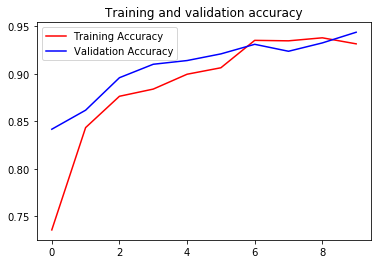

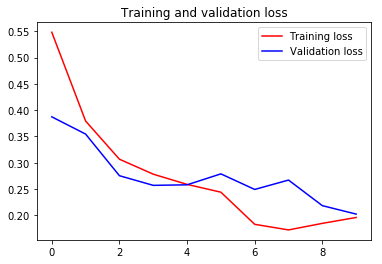

In [13]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **Convolution model**

### Building 2 individual models. Different zoom levels fed to each

In [10]:
window_size = 150

In [11]:
model_conv_1 = models.Sequential()
model_conv_1.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
model_conv_1.add(layers.MaxPooling2D((2, 2)))

model_conv_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_1.add(layers.MaxPooling2D((2, 2)))

model_conv_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_1.add(layers.MaxPooling2D((2, 2)))

model_conv_1.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_conv_1.add(layers.MaxPooling2D((2, 2)))

model_conv_1.add(layers.Flatten())
model_conv_1.add(layers.Dense(128, activation='relu'))
model_conv_1.add(layers.Dense(1, activation='sigmoid'))
model_conv_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 32)        18464     
__________

In [28]:
#np.sum(y_train_1_aug)
y_train_1_aug.shape

(23540,)

In [ ]:
from keras import optimizers

model_conv_1.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history_1 = model_conv_1.fit(X_train_1_aug,
          y_train_1_aug,
          epochs=10,
          batch_size=128,
          validation_data=(X_val_1_aug, y_val_1_Aug))


model_filename = "Convolution_multi_scale_simple_avg_1" + '_MODEL.h5' 
model_conv_1.save(model_filename)

Train on 23540 samples, validate on 11595 samples
Epoch 1/10
23540/23540 [==============================] - 79s 3ms/step - loss: 0.6043 - acc: 0.7698 - val_loss: 0.4542 - val_acc: 0.8006

In [13]:
model_conv_2 = models.Sequential()
model_conv_2.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
model_conv_2.add(layers.MaxPooling2D((2, 2)))

model_conv_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_2.add(layers.MaxPooling2D((2, 2)))

model_conv_2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_conv_2.add(layers.MaxPooling2D((2, 2)))

model_conv_2.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_conv_2.add(layers.MaxPooling2D((2, 2)))

model_conv_2.add(layers.Flatten())
model_conv_2.add(layers.Dense(128, activation='relu'))
model_conv_2.add(layers.Dense(1, activation='sigmoid'))
model_conv_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 128)     3584      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        73792     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 32)        18464     
__________

In [16]:
from keras import optimizers

model_conv_2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

history_2 = model_conv_2.fit(X_train_2_aug,
          y_train_2_aug,
          epochs=7,
          batch_size=128,
          validation_data=(X_val_2_aug, y_val_2_Aug))


model_filename = "Convolution_multi_scale_simple_avg_2" + '_MODEL.h5' 
model_conv_2.save(model_filename)

Train on 23540 samples, validate on 11595 samples
Epoch 1/7
23540/23540 [==============================] - 40s 2ms/step - loss: 0.2975 - acc: 0.8755 - val_loss: 0.3360 - val_acc: 0.8542

## Merged convolution model definition

Below model is designed to take inputs from 2 zoom levels and give a single output similar to merged transfer

In [17]:
window_size = 150

zoom_in_model = models.Sequential()
zoom_in_model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
zoom_in_model.add(layers.MaxPooling2D((2, 2)))

zoom_in_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
zoom_in_model.add(layers.MaxPooling2D((2, 2)))

zoom_in_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
zoom_in_model.add(layers.MaxPooling2D((2, 2)))

zoom_in_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
zoom_in_model.add(layers.MaxPooling2D((2, 2)))



zoom_out_model = models.Sequential()
zoom_out_model.add(layers.Conv2D(128, (3, 3), activation='relu',
                        input_shape=(window_size, window_size, 3)))
zoom_out_model.add(layers.MaxPooling2D((2, 2)))

zoom_out_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
zoom_out_model.add(layers.MaxPooling2D((2, 2)))

zoom_out_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
zoom_out_model.add(layers.MaxPooling2D((2, 2)))

zoom_out_model.add(layers.Conv2D(32, (3, 3), activation='relu'))
zoom_out_model.add(layers.MaxPooling2D((2, 2)))

input_1 = zoom_in_model.input
output_1 = zoom_in_model.output


for layer in zoom_out_model.layers:
    layer.name = layer.name + str("_zoom_out")

input_2 = zoom_out_model.input
output_2 = zoom_out_model.output


parallel_model_output = concatenate([output_1, output_2])

flat = Flatten()(parallel_model_output)
dense1 = Dense(256, activation='relu')(flat)
dropit = Dropout(.5)(dense1)
final_output = Dense(1, activation='sigmoid')(dropit)

merged_model = Model([input_1, input_2], final_output)

merged_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_9_input (InputLayer)     (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_13_input (InputLayer)    (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 148, 148, 128 3584        conv2d_9_input[0][0]             
__________________________________________________________________________________________________
conv2d_13_zoom_out (Conv2D)     (None, 148, 148, 128 3584        conv2d_13_input[0][0]            
__________________________________________________________________________________________________
max_poolin

In [21]:


from keras import optimizers

merged_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])


history = merged_model.fit_generator(
    train_generator,
    epochs=7,
    steps_per_epoch=128,
    validation_steps=64,
    validation_data=val_generator)

model_filename_2 = "Convolution_multi_scale_final_merged" + '_MODEL.h5' 
merged_model.save(model_filename_2)

Epoch 1/7
128/128 [==============================] - 10s 78ms/step - loss: 0.4130 - acc: 0.8198 - val_loss: 0.3822 - val_acc: 0.8296

Please note : graph below was run for initial 10 epochs that we ran the model for

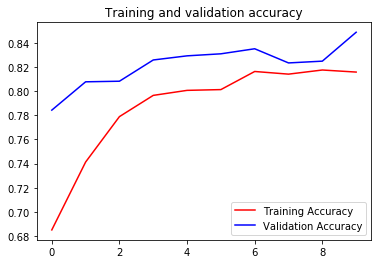

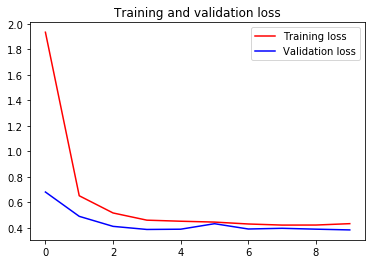

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Results obtained -
All models achieve a decent training and validation accuracy. We have observed that the transfer learning model achieves a higher accuracy, in 90's while the convolution models have accuracies in 80's.

We save all 6 learned models in different files.

The merged transfer learning model and merged convolution models are single models that take inputs from two zoom levels (4 and 5 in our case) and gives a single output denoting the probability of cancer. While testing on slide images, we decided to focus on these two models as we felt we it gave a better insight into detail and context that we wanted to capture rather than simply doing an average in the end.

The approach to take average of the output of two models was discarded early on, as we felt that the merged model gave a more informed result (since it captures both detail and context). The merged model also has a relatively higher accuracy, recall and precision than the average model in our experiments.